# Filtering results stored in tables based on IDs

In [33]:
def fetch_industries(lang='EN'):
    """
    fetches industries from the database

    Args:
    lang (str): language of the industries to fetch (EN or FR)

    Returns:
    list: list of industries in the table
    """
    
    conn = sqlite3.connect('identifiers.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT id, name FROM industries where lang = '{lang}'")
    industries = cursor.fetchall()
    conn.close()
    return industries

In [34]:
fetch_industries()

[(1, 'Plant / Machine / Metal construction'),
 (2, 'Aviation / Logistics / Transport / Traffic'),
 (3, 'Banking'),
 (4, 'Construction industry / Real estate'),
 (5, 'Clothing / Textiles'),
 (6, 'Education system'),
 (7, 'Biotechnology / Chemistry / Pharmaceutical'),
 (8, 'Retail business'),
 (9, 'Services'),
 (10, 'E-business / Internet'),
 (11, 'Electronics / Electrotechnical'),
 (12, 'Power / Water supply'),
 (13, 'Waste management / Recycling / Environmental technology'),
 (14, 'Automotive market'),
 (15, 'Precision mechanics / Optics / Watch and clock industry'),
 (16, 'Finance / Accounting'),
 (17, 'Science and research'),
 (18, 'Forestry / Agriculture'),
 (19, 'Leisure / Culture / Sports'),
 (20, 'Catering / Hotel business / Tourism'),
 (21, 'Agri-food industry'),
 (22, 'Healthcare'),
 (23, 'Small and medium-sized industries'),
 (24, 'Glass / Plastic / Paper industry'),
 (25, 'Graphic industry / Media / Publishing'),
 (26, 'Wholesale'),
 (27, 'Human resources / Personnel services

In [74]:
def filter_jobs(industry_ids: list = list(range(1,100)), employement_type_id: list = [1, 2, 3, 4, 5, 6], employement_position_id: list = [1, 2, 3]) -> list:
    """
    fetches jobs from the database filtered by industry and that are still active

    Args:
    industry_ids (list): list of ids of industries to filter by
    employement_type_id (list): list of ids of employment types to filter by
    employement_position_id (list): list of ids of employment positions to filter by

    Returns:
    list: list of jobs in the table
    """
    
    conn = sqlite3.connect('jobs.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM jobs WHERE industry IN ({','.join([str(i) for i in industry_ids])}) AND employmentTypeIds IN ({','.join([str(i) for i in employement_type_id])}) AND employmentPositionIds IN ({','.join([str(i) for i in employement_position_id])}) AND publicationEndDate > date('now')")
    jobs = cursor.fetchall()
    conn.close()
    return jobs

# Ai Agent

In [1]:
import os
from dotenv import load_dotenv
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# For demonstration, let's assume these come from your environment
# or the same as your tutorial references:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

#from src.profile_agent.agent_classes import *
#from src.profile_agent.agent_functions import *

load_dotenv()

# I need to generate an LLm that will create a structured base user profile from the user's CV and cover letter

True

### Classes

In [3]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI

from llm_config import LLMFactory

## Data formats

class UserProfile(BaseModel):
    """
    A class used to represent a user profile
    """
    name: str = Field(description="User's name"    )
    work_experience: str = Field(description="User's work experience")
    skills: str = Field(description="User's skills")
    education: str = Field(description="User's education")
    certifications: str = Field(description="User's certifications")
    other_info: str = Field(description="Other relevant information")

class UserProfileBuilderAssistant(BaseModel):
    """
    A class used to represent a user profile builder assistant
    """
    name: str = Field(description="Name of the analyst.")
    industry: str = Field(description="The industry of the assistant",)
    description: str = Field(description="Description of the analyst focus, concerns, and motives.",)
    @property
    def persona(self) -> str:
        return f"Name: {self.name} \n Specialty: {self.industry}\n Description: {self.description}"
    

class Perspectives(BaseModel):
    """
    A class used to represent the perspectives of the user profile builder assistants
    """
    industry_experts: List[UserProfileBuilderAssistant] = Field(
        description="List of user profile builder assistants."
    )

class SpecializedProfiles(BaseModel):
    """
    A class used to represent the specialized profiles of the user built by the profile builder assistants
    """
    specialized_profile: List[UserProfile] = Field(
        description="List of specialized user profiles."
    )

class IndustryList(BaseModel):
    """
    A class used to represent a list of industries
    """
    selected_industries: List[str] = Field(
        description="List of industries the person could work in"
    )


## States

class ProfileState(TypedDict):
    """
    A class used to represent the state of the profile generation
    """
    user_docs: List[str]
    user_profile: UserProfile
    #keyword_list: Annotated[list, operator.add]
    selected_industries: IndustryList
    job_ids: Annotated[list, operator.add]
    max_industry_experts: int
    max_num_turns: int
    results_to_retrieve: int
    industry_experts: List[UserProfileBuilderAssistant]
    user_feedback: str
    chroma_path: str
    all_jobs: List[str]

class SingleProfileState(TypedDict):
    """
    State used in the subgraph that creates exactly one specialized profile
    for a single industry-expert assistant.
    """
    user_profile: UserProfile
    in_progress_profile: str # We'll fill this in
    max_num_turns: int
    industry_expert: UserProfileBuilderAssistant
    messages: List[str]  # if you want to store the conversation turn-by-turn
    keyword_list: str
    chroma_path: str
    job_ids: List

In [12]:
import sys
print("\n".join(sys.path))


c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\python311.zip
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\DLLs
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial

c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\win32
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\win32\lib
c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\Pythonwin
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend\--
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend\apps
c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy


### Functions

In [ ]:
import sys
import os

# Get the absolute path to the root directory ('Lucy')
root_path = os.path.abspath(os.path.join(os.getcwd(), '../../../'))  # Adjust path to reach 'Lucy'
if root_path not in sys.path:
    sys.path.append(root_path)

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "backend.settings")
import django
django.setup()


from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from backend.apps.job_scraping.models import Job
from backend.settings import JOB_ADS_EMBEDDINGS_PATH
from llm_config import LLMFactory
from asgiref.sync import sync_to_async, async_to_sync


# Custom functions
from backend.apps.job_scraping.constants import fetch_industries

## Import classes
#from src.profile_agent.agent_classes import *

def create_base_profile(state: ProfileState) -> dict:
    """
    Creates a summary of the user's profile.

    Args:
    user_docs (List[str]): list of user documents

    Returns:
    str: user profile summary
    """

    system_message = """Your task is to create a detailed user work profile. The user has provided the following documents:
    A CV (please note the content of the CV may be in a strange order due to the format of the document. Please try to reconstruct it in a way that makes sense): 
    {cv}

    A cover letter: 
    {cover_letter}

    Take into consideration the optionally provided user feedback to improve the quality of the generated profile:

    {user_feedback}
    
    Please generate a detailed user profile based on these documents and optional feedback.
    The profile must include the following sections:
    (a) The user's name
    (b) Work experiences
    (c) Skills
    (d) Education
    (e) Certifications
    (f) Other information
    
    Be exhaustive and do not leave any important experience out.
    However, and this is crucial, do not invent anything. 
    If the provided documents and user feedback do not permit you to generate a section, leave it empty.
    I REPEAT: DO NOT INVENT ANY INFORMATION! LEAVE BLANK IF YOU CANNOT ANSWER!

    For example, do not write:
    - Sales Manager at ABC Company
    - Marketing Specialist at XYZ Company
    - Bachelors degree in Computer Science from ABC University
    
    Instead leave it blank.
    """

    system_message = system_message.format(
        cv=state['user_docs'][0],
        cover_letter=state['user_docs'][1], 
        user_feedback=state.get('user_feedback', '')
        )
        
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(UserProfile)
    
    # Update the state with the generated base_profile
    detailed_profile= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate the user profile please?")])

    return {"user_profile": detailed_profile}

def human_feedback(state: ProfileState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: ProfileState) -> str:
    """ Return the next node to execute """
    
    # Check if human feedback is present
    human_feedback = state.get('user_feedback', None)
    if human_feedback:
        return "create_base_profile"
    
    # Otherwise continue
    return "get_list_of_possible_industries"


def get_list_of_possible_industries(state: ProfileState) -> dict:
    """
    Fetches a list of possible industries for the user profile

    Args:
    state (GenerateProfileState): state of the profile generation

    Returns:
    list: list of possible industries
    """
    all_industries = fetch_industries()
    
    system_message = """Your task is to generate a list of possible industries that the user could work in based on their profile. 
    The user has the following profile:
    {user_profile}

    The possible industries are:
    {all_industries}
    
    Please generate a list of the {max_industry_experts} most likely possible industries that the user could work in.
    """

    system_message = system_message.format(
        user_profile=state.get('user_profile'),
        all_industries=all_industries,
        max_industry_experts=state.get('max_industry_experts')
        )

    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(IndustryList)
    
    # Update the state with the generated base_profile
    selected_industries= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate a list of possible industries for the user profile please?")])

    return {"selected_industries": selected_industries}

def create_profile_builder(state: ProfileState):
    """
    Creates a set of AI assistants to help users build their work profiles.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    dict: profile builder assistants
    """

    max_industry_experts = state['max_industry_experts']
    user_profile = state['user_profile']
    selected_industries = state['selected_industries']

    #Enforce structured output
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(Perspectives)

    profile_builder_instructions= """You are tasked with creating a set of AI assistants. The purpose of these assistants is to help users build their work profiles. 

        1. First, review the detailed user profile
        {user_profile}

        2. Then review the list of possible industries that the user could work in : {selected_industries}

        3. Based on the user profile and the list of possible industries, create one specialized industry expert for each industry in the list, that is {max_industry_experts} industry experts in total.
        """
    
    
    # System message
    system_message = profile_builder_instructions.format(user_profile=user_profile,
                                                         max_industry_experts=max_industry_experts,
                                                         selected_industries=selected_industries)
    
    # Generate question
    profile_assistant_results = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of profile builder assistants.")])

    # Write the list of assistants to state
    return {"industry_experts": profile_assistant_results.industry_experts}

def industry_expert_node(state: SingleProfileState):
    """
   Generates a specialized profile from the perspective of an industry expert.
   Asks an HR expert to review the specialized profile.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """
    # Get state
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']

    # Write system message
    in_progress_profile_instructions = """You are an industry expert. 
    Your task is to generate a specialized profile for the user based on the user's detailed profile and the possible industrie that the user could work in.
    You will work together with an HR expert to perfect the profile and make the user stand out in the job market.
    
    The purpose of this profile down the line will be to perform similarity search between this user profile and jobs descriptions. 
    Therefore, it is important that the specialized profile you create be as detailed as possible and contain as many relevant keywords as possible while staying true to the actual profile of the user.
    
    1. First, review your persona: {industry_expert.persona}.
    
    2. Second, review the user profile: {user_profile}.

    3. Third, based on the user profile and the possible industries, generate a specialized profile for the user.
    
    4. Continue to review this profile with the HR expert until it is perfect.

    When you are satisfied with the profile say: "I think we are done!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    in_progress_profile_instructions = in_progress_profile_instructions.format(industry_expert=industry_expert, 
                                                                               user_profile=user_profile,
                                                                               in_progress_profile=in_progress_profile)

    in_progress_profile_result = llm.invoke([SystemMessage(content=in_progress_profile_instructions)]+[HumanMessage(content="Generate the specialized profile.")])

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(in_progress_profile_result)
    
    return {"in_progress_profile": [in_progress_profile_result.content]}

def hr_expert_node(state: SingleProfileState):
    """
    Helps the industry expert refine the user profile

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """

    # Get state
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']


    help_industry_expert_instructions = """ You are an HR expert with a focus on recruitment and many years of experience in the field.
    Your task is to help the industry expert refine the user profile. 
    
    1. Here is the industry expert's area of focus: {industry_expert.persona}

    2. Here is the user's detailed profile: {user_profile}

    3. Here is the specialized profile they have created: {in_progress_profile}
    
    Please refine or improve the specialized profile.
    When you think it's good, say "I think we are done!"
    """

    help_industry_expert_instructions = help_industry_expert_instructions.format(industry_expert=industry_expert, 
                                                                                 user_profile=user_profile, 
                                                                                 in_progress_profile=in_progress_profile)
    
    revised_profile = llm.invoke([SystemMessage(content=help_industry_expert_instructions)]+[HumanMessage(content="Review the specialized profile.")])

    revised_profile.name = "hr"

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(revised_profile)
    
    return {"in_progress_profile": [revised_profile.content]}

def spawn_specialized_profiles(state: ProfileState):
    """
    This node spawns parallel sub-runs, each calling `single_profile_graph_compiled`.
    """
    # Get the state
    industries = state["selected_industries"].selected_industries
    industry_experts = state["industry_experts"]
    
    # zip over them:
    sends = []
    for industry, expert in zip(industries, industry_experts):
        # Create a sub-state for single_profile_graph_compiled
        single_sub_state = {
            "industry_expert": expert,
            "user_profile": state.get('user_profile'),
            "in_progress_profile": "",
            "messages": [],
            "chroma_path": state.get('chroma_path'),
        }
        # We'll spawn a parallel run
        sends.append(Send("create_specialized_profile", single_sub_state))
    return sends

def route_messages(state: SingleProfileState, name: str = "hr"):
    """
    Route between question and answer, continuing until some end condition.
    """
    # Suppose we store all messages in state["messages"]
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 1)

    # Count how many times the AI (with name=hr) has responded
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if the HR expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "format_specialized_profile"

    # Alternatively, if a certain user message indicates we’re done
    last_question = messages[-2] if len(messages) >= 2 else None
    if last_question and "I think we are done!" in last_question.content:
        return "format_specialized_profile"

    # Otherwise keep going
    return "industry_expert_node"


def format_specialized_profile(state:SingleProfileState):
    """ 
    Takes the raw in_progress_profile and formats it for job retrieval
    """

    in_progress_profile = state['in_progress_profile']
    llm_factory = LLMFactory()
    llm = llm_factory.get_llm(model_key='gpt-4o')

    profile_formatting_instructions = """"You are an expert in recruitement. 
    You specialize in transforforming a user's profile into a list of keywords that are relevant to jobs. 

    You will be given a user profile, and your task is to create an extensive list of keywords, based on the profile, that may be present in job openings that are relevant to that user.

    Later on, these keywords will be used to perform cosine similarity between these keywords and job listings to retrieve jobs that are relevant to the user.

    Here is the user profile: {in_progress_profile}

    Create as many keywords as possible, but base them on the actual experiences of the user, as written in their profile.
    """

    profile_formatting_instructions=profile_formatting_instructions.format(in_progress_profile=in_progress_profile)

    keyword_list= llm.invoke([SystemMessage(content=profile_formatting_instructions)]+[HumanMessage(content='Please create the list of keywords')])

    return {'keyword_list': keyword_list.content}

def retrieve_id_similarity_search(state: SingleProfileState) -> ProfileState:
    
    # Get the state
    chroma_path = state.get('chroma_path')
    keyword_list = state.get('keyword_list')
    results_to_retrieve = state.get('results_to_retrieve', 5)

    # Initialize the embeddings
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
    
    # Initialize the Chroma vector store
    vector_store = Chroma(
    collection_name="job_ads_embeddings",
    embedding_function=embeddings,
    persist_directory=chroma_path)
    
    results = vector_store.similarity_search_with_relevance_scores(
        keyword_list,
        k=results_to_retrieve,
    )
    id_list = []
    for res in results:
        id_list.append(res[0].id)
        #print(res[0].id)
        # print(f"{res[0].metadata['job_title']} - {res[0].metadata['company_name']} \n \n")
        # print(f"{res[0].page_content} \n \n")
        # print(f"score: {res[1]} \n \n")
    
    return {'job_ids': [id_list]}


async def retrieve_jobs_from_ids(state: ProfileState) -> dict:
    """
    Asynchronously retrieves Job records based on job IDs stored in the state using Django ORM.
    
    Args:
        state (ProfileState): The state containing job_ids.
    
    Returns:
        dict: A dictionary with the key 'all_jobs' mapping to a list of tuples
              (id, company_name, template_title, template_lead) for each Job.
    """
    # Retrieve the job_ids from the state.
    ids = state.get('job_ids', [])
    # Flatten the list of lists and remove duplicates.
    ids = list(set(item for sublist in ids for item in sublist))
    
    # Use sync_to_async to wrap the ORM call and await the result.
    jobs_qs = await sync_to_async(
        lambda: list(
            Job.objects.filter(id__in=ids).values_list('id', 'company_name', 'template_title', 'template_lead')
        )
    )()
    
    return {'all_jobs': jobs_qs}

### New Code

In [2]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o")
# # llm.invoke("Hello, world!")

In [10]:
# # Get state and look at next node
# state = graph.get_state(thread)
# state.next

# # We now update the state as if we are the human_feedback node
# graph.update_state(thread,
#                    {"user_feedback": r"from 2017 to 2018 I co-founded LeCycle, a 'circular economy' startup that recycled used coffee grounds from restaurants and cafe's in Lausanne by using it to grow edible oyster mushrooms."},
#                    as_node="human_feedback"
#                    )
# New work experience correctly. No further human feedback needed

# further_feedback = None
# graph.update_state(thread,
#                      {"user_feedback": further_feedback},
#                      as_node="human_feedback"
#                      )

('human_feedback',)

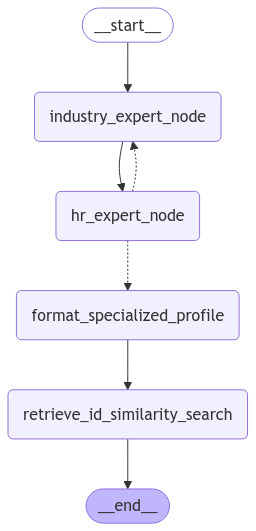

In [5]:
# Build subgraph

single_profile_builder = StateGraph(SingleProfileState)
single_profile_builder.add_node("industry_expert_node", industry_expert_node)
single_profile_builder.add_node("hr_expert_node", hr_expert_node)
single_profile_builder.add_node("format_specialized_profile", format_specialized_profile)
single_profile_builder.add_node("retrieve_id_similarity_search", retrieve_id_similarity_search)

single_profile_builder.add_edge(START, "industry_expert_node")
single_profile_builder.add_edge("industry_expert_node", "hr_expert_node")
single_profile_builder.add_conditional_edges('hr_expert_node', route_messages, ['industry_expert_node', 'format_specialized_profile'])
single_profile_builder.add_edge('format_specialized_profile', 'retrieve_id_similarity_search')
single_profile_builder.add_edge('retrieve_id_similarity_search', END)

memory = MemorySaver()
single_profile_graph = single_profile_builder.compile(checkpointer=memory).with_config(run_name="single_profile_graph")

display(Image(single_profile_graph.get_graph().draw_mermaid_png()))

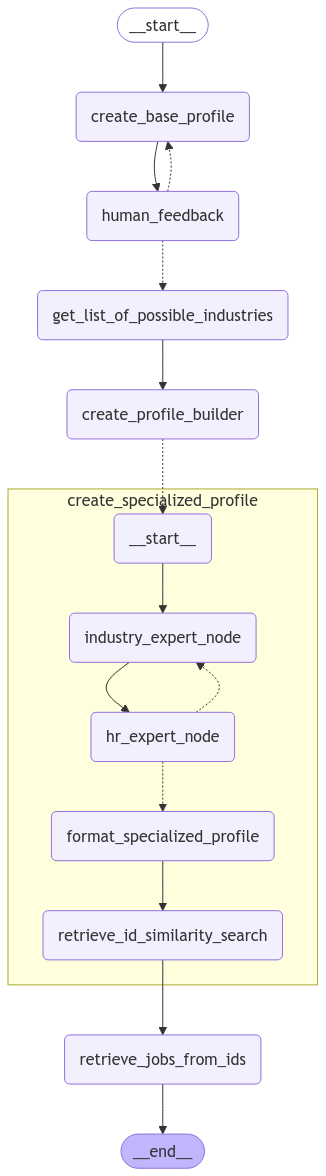

In [6]:
# Build overall graph

# Add nodes
builder = StateGraph(ProfileState)
builder.add_node("create_base_profile", create_base_profile)
builder.add_node("human_feedback", human_feedback)
builder.add_node("get_list_of_possible_industries", get_list_of_possible_industries)
builder.add_node("create_profile_builder", create_profile_builder)
builder.add_node("create_specialized_profile", single_profile_builder.compile())  # <-- rename
builder.add_node("retrieve_jobs_from_ids", retrieve_jobs_from_ids)

# Graph flow
builder.add_edge(START, "create_base_profile")
builder.add_edge("create_base_profile", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_base_profile", "get_list_of_possible_industries"])
builder.add_edge("get_list_of_possible_industries", "create_profile_builder")
builder.add_conditional_edges("create_profile_builder", spawn_specialized_profiles, ["create_specialized_profile"])
builder.add_edge("create_specialized_profile", "retrieve_jobs_from_ids")
builder.add_edge("retrieve_jobs_from_ids", END)


# Compile
memory = MemorySaver()
graph = builder.compile(#interrupt_before=["human_feedback"], 
                        checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
from backend.apps.data_processing.process_documents import process_cv, process_cover_letter
#from src.profile_agent.agent_classes import ProfileState
from backend.settings import JOB_ADS_EMBEDDINGS_PATH

file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]
thread = {"configurable": {"thread_id": "1"}}

test_state = ProfileState(
    user_docs=[process_cv(file_paths[0]), process_cover_letter(file_paths[1])],
    max_industry_experts=1,
    max_num_turns=1,
    results_to_retrieve=5,
    human_feedback=None,
    chroma_path=JOB_ADS_EMBEDDINGS_PATH
    )

final_state = await graph.ainvoke(test_state, thread)

SynchronousOnlyOperation: You cannot call this from an async context - use a thread or sync_to_async.

In [15]:
from backend.settings import JOB_ADS_EMBEDDINGS_PATH

print(JOB_ADS_EMBEDDINGS_PATH)

c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\data\job_ads_embeddings


In [11]:
current_state = graph.get_state(thread)

In [12]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [13]:
def print_jobs(thread):
    current_state = graph.get_state(thread)
    for item in current_state.values['all_jobs']:
        print(f'Job id: {item[0]}')
        print(f'Company Name: {item[1]}')
        print(f'Job title: {item[2]} \n')
        print('Job description: \n')
        print(f'{item[3]}')
        print('-'*50)
        print('\n')

print_jobs(thread)

Job id: 3003da3a-9e0e-45ae-a042-36025458c29c
Company Name: Bulgari Horlogerie SA
Job title: Senior Data Analyst 

Job description: 

In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :

As a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to

In [14]:
# from langgraph.errors import InvalidUpdateError

test = graph.invoke(current_state.values, current_state.config)

Chroma path: None
Keyword list: Certainly! Based on Tyler R. Kleinbauer's profile, here is an extensive list of keywords:

1. Data Science
2. Analytics Engineering
3. Machine Learning
4. Advanced Machine Learning Models
5. Explainable ML Models
6. Predictive Analytics
7. Data-driven Decision Making
8. Consultancy
9. Data Process Automation
10. Secure Data Interactions
11. Customer Engagement
12. Chatbot Development
13. Retrieval Augmented Generation (RAG)
14. Open-source LLMs
15. Snowpark
16. Data Ingestion
17. Error Monitoring
18. Data Accuracy
19. Role Mining Dashboards
20. IAM Department
21. User Role Creation
22. Compliance Monitoring
23. Tableau
24. Tableau Prep
25. Data Visualization
26. Programming Languages
27. Python
28. SQL
29. R
30. Stata
31. JavaScript
32. Django
33. React
34. Tools & Platforms
35. Snowflake
36. AWS
37. Dataiku
38. Docker
39. Git
40. Python Libraries
41. LangChain
42. OpenAI
43. NumPy
44. Scikit-learn
45. pandas
46. TensorFlow
47. Matplotlib
48. Keras
49. S

In [41]:
test.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [27]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [ ]:
profile = ProfileState({'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPresentation Skills, Leadership,\nProblem-solving\n\n\n\n\n\nTyler      R.  Kleinbauer,            PhD\n\n\nData  Scientist and Analytics Engineer\nWORK EXPERIENCE\n\nARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023\nMachine Learning and Data Science:\n• Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n• Developed two chatbots using Streamlit:\n○ Secure Data Chatbot: Securely used Retrieval Augmented Generation\n(RAG) and open-source LLMs on internal data within Snowflake.\n○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website visitor questions using OpenAI and Huggingface APIs.\nAutomation and Data Engineering:\n• Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n• Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\nDashboards and Reporting:\n• Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n• Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\nTraining and Development:\n• Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\nUNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER | 2018 – 2022\nMachine Learning and Advanced Analytics:\n• Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n• Conducted dimensionality reduction and data preprocessing for various research projects.\nQuantitative Research:\n• Analyzed the impact of leadership on U.S. State GDP growth.\n• Evaluated ML estimator performance through Monte Carlo simulations.\nProject Leadership and Academic Contributions.\n• Led multiple research projects from inception to completion.\n• Presented research at international conferences and taught courses in\nOrganizational Behavior, Statistics for Causal Analysis, and Leadership.\n\nALAYA SA – DATA SCIENCE CONSULTANT | 2020- 2021\nData Science Strategy Development:\n• Developed strategies for data collection and analysis to assess platform impacts.\n• Identified key variables for analysis, enhancing data-driven insights.\n\nEDUCATION\nPhD in Economics - University of Lausanne\n2018 – 2022 (5.5/6 GPA)\nAwards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne\n2015 – 2017 (5/6 GPA)\n• Exchange Year - Telfer School of Management, Ottawa, Canada, 2014 – 2015 (5/6 GPA)\nBachelor of Science - University of Lausanne\n2013 – 2015 (4.7/6 GPA)",
  "À l’attention de l’équipe Talent Acquisition.\n\n\nJe suis très enthousiaste à l'idée de postuler pour le poste d’Ingénieur.e Data et Machine Learning R&I au sein du Groupe Richemont. Rita Drissi Daoudi, de l’équipe matériaux en R&I, m’ai fait part de cette\nopportunité passionnante. Mon parcours de 7 ans en Data Science et Machine Learning, allié à mon esprit entrepreneurial et à ma capacité à lier les méthodes techniques aux objectifs commerciaux, me motive à\npostuler pour ce rôle.\n\nLa force qui m’anime est une curiosité pour les nouvelles technologies et un désir d’y trouver des applications concrètes et utiles. Par exemple, j'ai initié le développement d'un bot Dockerisé déployé sur\nAWS et Snowflake pour automatiser la collecte de données via web scraping. Ce projet, né de ma propre initiative, permet de partager automatiquement des insights quotidiens de nos partenaires avec l'équipe\nArgusa via Slack. Cette expérience démontre ma capacité à innover, à travailler de manière autonome et à piloter des projets de bout en bout.\nMon intérêt pour la technologie et l'innovation ma également poussé à développer deux chatbots, l'un sécurisé, utilisant des LLMs open source sans sortie d’informations confidentielles, utilisant la ‘retrieval\naugmented generation’ (RAG) sur des données internes, et l'autre, un proof-of-concept pour les visiteurs de notre site web, utilisant les API OpenAI et Huggingface. Ces projets illustrent ma capacité à concevoir\net à déployer des solutions techniques avancées qui répondent aux besoins de l'entreprise.\n\nBien entendu, mon rôle de ‘Data Science et Analytics Engineering Consultant’ chez Argusa m’amène également à gérer des projets clients de la conception à la mise en production, assurant une livraison\noptimale des solutions, par exemple lorsque j’ai conçu et déployé en production des outils de rôle mining pour un horloger international basé à Genève.\n\nDurant mon doctorat à l'Université de Lausanne, j'ai acquis une solide expertise en Data Science et\nMachine Learning, tout en supervisant des assistants de recherche. Cette expérience m'a permis de développer des compétences en gestion de projet, d’équipe et en leadership, essentielles pour guider\ntechniquement d'autres membres de l'équipe R&I Digital Tech ML Lab.\nMon approche analytique et orientée vers les résultats m'a conduit à mettre en place des initiatives marketing chez Argusa. J'ai mené la refonte du site web, la gestion des médias sociaux et l'organisation\nd'événements, tout en créant des tableaux de bord de reporting pour évaluer le coût et le retour sur investissement. Cette démarche démontre mon œil attentif au ROI et ma capacité à aligner les efforts\ntechniques avec les objectifs commerciaux.\n\nEn rejoignant Richemont, je souhaite apporter cette même énergie entrepreneuriale et cette capacité d'innovation pour transformer vos Maisons et manufactures. Mon expertise en développement de\nsolutions de Machine Learning et mon engagement à rester à la pointe des avancées technologiques seront des atouts pour contribuer à la stratégie R&I Digital Tech ML Lab.\n\nJe serais honoré de discuter plus en détail de la manière dont je pourrais apporter ma contribution à\nRichemont et participer à l'élaboration de solutions innovantes et impactantes. Je vous remercie de l'attention portée à ma candidature et j'espère avoir l'opportunité de vous rencontrer prochainement.\n\n\nCordialement,\n\nTyler R. Kleinbauer"],
 'user_profile': UserProfile(name='Tyler R. Kleinbauer, PhD', work_experience="1. ARGUSA SA – Data Science and Analytics Engineering Consultant (from 2023)\n   - Machine Learning and Data Science:\n     • Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n     • Developed two chatbots using Streamlit: Secure Data Chatbot (using RAG and open-source LLMs on internal data within Snowflake) and a Client-facing Chatbot (proof-of-concept RAG chatbot using OpenAI and Huggingface APIs).\n   - Automation and Data Engineering:\n     • Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n     • Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\n   - Dashboards and Reporting:\n     • Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n     • Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\n   - Training and Development:\n     • Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\n\n2. UNIL – Data Scientist and Doctoral Researcher (2018 – 2022)\n   - Machine Learning and Advanced Analytics:\n     • Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n     • Conducted dimensionality reduction and data preprocessing for various research projects.\n   - Quantitative Research:\n     • Analyzed the impact of leadership on U.S. State GDP growth.\n     • Evaluated ML estimator performance through Monte Carlo simulations.\n   - Project Leadership and Academic Contributions:\n     • Led multiple research projects from inception to completion.\n     • Presented research at international conferences and taught courses in Organizational Behavior, Statistics for Causal Analysis, and Leadership.\n\n3. ALAYA SA – Data Science Consultant (2020-2021)\n   - Data Science Strategy Development:\n     • Developed strategies for data collection and analysis to assess platform impacts.\n     • Identified key variables for analysis, enhancing data-driven insights.", skills='Programming Languages: Python, SQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS, Dataiku, Tableau, Docker, Git\nPython Libraries: LangChain, OpenAI, NumPy, Scikit-learn, pandas, TensorFlow, Matplotlib, Keras, Selenium, Streamlit\nFrameworks: Django, React\nLanguages: English, French (native), German (beginner)\nSoft Skills: Project Management, Presentation Skills, Leadership, Problem-solving', education='PhD in Economics - University of Lausanne (2018 – 2022, 5.5/6 GPA)\n   - Awards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne (2015 – 2017, 5/6 GPA)\n   - Exchange Year - Telfer School of Management, Ottawa, Canada (2014 – 2015, 5/6 GPA)\nBachelor of Science - University of Lausanne (2013 – 2015, 4.7/6 GPA)', certifications='Snowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization', other_info='Email: tyler.kleinbauer@gmail.com\nPhone: +41 78 649 97 85\nLinkedIn: https://www.linkedin.com/in/tylerkleinbauer/'),
 'keyword_list': [],
 'selected_industries': IndustryList(selected_industries=['Consultancy']),
 'max_industry_experts': 1,
 'industry_experts': [UserProfileBuilderAssistant(name='Dr. Tyler Kleinbauer - Consultancy Expert', industry='Consultancy', description='Dr. Tyler Kleinbauer is a seasoned expert in consultancy, specializing in data science and analytics engineering. With a robust background in machine learning, data science strategies, and project leadership, Dr. Kleinbauer leverages his extensive experience working with prestigious organizations such as ARGUSA SA and ALAYA SA. His focus is on helping consultancy firms optimize their data analytics capabilities, develop automation processes, and enhance decision-making through advanced yet explainable machine learning models. Driven by a passion for innovation, Dr. Kleinbauer aims to empower consultancy firms by improving their data-driven insights and helping them stay competitive in a rapidly evolving industry. His expertise also extends to developing impactful training programs to elevate the skill sets of consultancy professionals.')],
 'llm': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000231E2ED5850>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000231E300D810>, root_client=<openai.OpenAI object at 0x00000231E2ED3250>, root_async_client=<openai.AsyncOpenAI object at 0x0000023198E6BAD0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))})

In [ ]:
import pprint
pprint.pprint(final_state)

NameError: name 'final_state' is not defined

In [20]:
all_states = [s for s in graph.get_state_history(thread)]

In [25]:
len(all_states)

6

In [29]:
pprint.pprint(all_states[0])

StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Pro

In [32]:
for s in range(len(all_states)):
    print(f'step number {s}')
    print(all_states[s])
    print ('-'*50)

step number 0
StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSo